In [185]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [186]:
'''
Protocol parameters!!!
'''
FFT = 64 # FFT size for extracting IQ sample in each subcarrier
OFDM_size = 80 # OFDM symbol with cyclic prefix
data_size = 48 # data_subcarriers
mess_length = 560

actual_message = 'I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.'


In [187]:
packet = 6000 # number of data bits per pseudonym symbol
samples = packet//10 # number of samples per chip
CP = 16
mod_index = 0.2 # decides the level of modification/modulation on the host signal
Pseudonym = 'STOP' # Pseudonym message we transmit. It's 28 bit bit sequence.

In [188]:
CP = FFT//4  # 25% cyclic prefix
pilotValue = 3+3j # known values for pilots

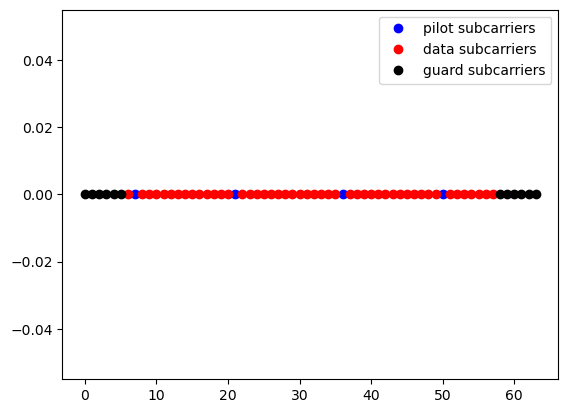

In [189]:
allCarriers = np.arange(FFT)  # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = np.array([7,21,36,50]) # Pilots indices.
guardCarriers = np.array([0,1,2,3,4,5,58,59,60,61,62,63]) # 6 subcarriers on each side
nondataCarriers = np.concatenate([pilotCarriers,guardCarriers])

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, nondataCarriers)

plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot subcarriers')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data subcarriers')
plt.plot(guardCarriers, np.zeros_like(guardCarriers), 'ko', label='guard subcarriers')
plt.legend()

In [190]:
# PURPOSE: Convert a text string to a stream of 1/0 bits.
# INPUT: string message
# OUTPUT: vector of 1's and 0's.
def text2bits(message):
    # Convert to characters of '1' and '0' in a vector.
    temp_message = []
    final_message = []
    for each in message:
        temp_message.append(format(ord(each), '07b'))
    for every in temp_message:
        for digit in every:
            final_message.append(int(digit))
    return final_message

In [191]:
# PURPOSE: convert input data stream to signal space values for
#          a particular modulation type (as specified by the inputVec
#          and outputVec).
# INPUT: data (groups of bits)
# OUTPUT: signal space values
def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('Input and Output vectors must have identical length')
    # Initialize output
    output = np.zeros(data.shape)
    # For each possible data value
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        # Find the indices where data is equal to that input value
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                # Set those indices in the output to be the appropriate output value.
                output[k] = outputVec[i]
    return output

In [192]:
# PURPOSE: Convert binary data to M-ary by making groups of log2(M)
#          bits and converting each bit to one M-ary digit.
# INPUT: Binary digit vector, with length as a multiple of log2(M)
# OUTPUT: M-ary digit vector
def binary2mary(data, M):
    length     = len(data)
    log2M   = round(math.log2(M)) # integer number of bits per group
    if (length % log2M) != 0:
        print('Input to binary2mary must be divisible by log2(m).')
    binvalues = np.zeros((log2M,1))
    values = []
    newdata = []
    start = log2M-1
    i = 0
    while start >= 0:
        binvalues[i] = int(math.pow(2,start))
        start=start-1
        i = i + 1
    for each in data:
        newdata.append(int(each))
    newdata = np.array(newdata)
    temp = np.reshape(newdata, (int(length/log2M), log2M))
    marydata = temp.dot(binvalues)
    return marydata

In [193]:
# Signal Generation
# INPUT: none
# OUTPUT: binary data
def Data_Frame(x):
    A = math.sqrt(9/2)
    plt.ion()

    if 1:
        temp =  x
        print('Lenght of message:',len(temp))
        messagebits  = np.array(text2bits(temp))    

        data_bits = messagebits
        print('Message Sent: ')
        print(temp)
        print('Number of data bits: ' + str(len(messagebits)))

        ###########################################
        ### Signal Generation
        ### INPUT: binary data
        ### OUTPUT: 4-ary data (0..3) values

        data = binary2mary(data_bits, 4)

        ###########################################
        ### Modulation
        ### INPUT: data
        ### OUTPUT: modulated values, x

        inputVec   = [0, 1, 2, 3]
        outputVecI = [A, -A, A, -A]
        outputVecQ = [A, A, -A, -A]
        xI         = lut(data, inputVec, outputVecI)
        xQ         = lut(data, inputVec, outputVecQ)
        xI = xI.reshape((1,len(data)))
        xQ = xQ.reshape((1,len(data)))

        x_s_I = np.reshape(xI, xI.size)
        x_s_Q = np.reshape(xQ, xQ.size)

        qpsk_IQ = x_s_I + 1j*x_s_Q

#         print("Length of QPSK_IQ:",len(qpsk_IQ))
#         plt.figure()
#         plt.plot(np.real(qpsk_IQ),label='Real Signal')
#         plt.plot(np.imag(qpsk_IQ),label='Imag Signal')
#         plt.grid('on')
#         plt.legend()
#         plt.show()
    return qpsk_IQ

In [194]:
''' Generate the OFDM time signal for the input QPSK signal'''

def OFDM_TX(data):
    for i in range(len(data)//data_size):
        
        QPSK_payload = data[i*data_size:(i+1)*data_size]
        
        symbol = np.zeros(FFT, dtype=complex) # the overall K subcarriers
        symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
        
        symbol[dataCarriers] = QPSK_payload  # allocate the pilot subcarriers
        
        # Generate time domain signal
        OFDM_time = np.fft.ifft(symbol,n=64)

        # adding cyclic prefix
        def addCP(x):
            cp = x[-CP:]              
            return np.hstack([cp, x]) 
        OFDM_withCP = addCP(OFDM_time)
        if i == 0:
            OFDM_swap = OFDM_withCP
        else:
            OFDM_signal = np.hstack([OFDM_swap, OFDM_withCP])
            OFDM_swap = OFDM_signal

    return OFDM_signal

In [195]:
'''Embedding the pseudonym watermark signal on to the OFDM host signal
Divide the ofdm packet into 10 window of samples of size 600 called chips
Send chips with alternative high and low power patterns which can be detected 
as power changes at the passive receiver.'''

def Pseudonym_embedding(x,message):
    modulated_signal = np.zeros(len(x), dtype=np.complex64)
    for i in range(int(len(x)/packet)):
        OFDM_packet = x[i*packet:(i+1)*packet]
        trancated_signal = np.zeros(len(OFDM_packet), dtype=np.complex64)
        if message[i] == 1.0:
            for j in range(10):
                if j%2 == 0:
                    trancated_signal[j*samples:(j+1)*samples] = (1+mod_index)*OFDM_packet[j*samples:(j+1)*samples]
                else:
                    trancated_signal[j*samples:(j+1)*samples] = (1-mod_index)*OFDM_packet[j*samples:(j+1)*samples]
        else:
            for j in range(10):
                if j%2 == 0:
                    trancated_signal[j*samples:(j+1)*samples] = (1-mod_index)*OFDM_packet[j*samples:(j+1)*samples]
                else:
                    trancated_signal[j*samples:(j+1)*samples] = (1+mod_index)*OFDM_packet[j*samples:(j+1)*samples]
        modulated_signal[i*packet:(i+1)*packet] = trancated_signal
    return modulated_signal

In [196]:
# Generate HTSTF signals for time synchronization
def Generate_HTSTF():
    data = scipy.io.loadmat('HTSTF.mat')
    new_data = data['stf'].reshape((1,len(data['stf'])))
    preamble = np.tile(new_data,10)[0]
    return preamble

In [197]:
''' Generate the watermark TX signal '''
def Generate_OFDM_Packet(x):
    # generate qpsk IQ samples from actual message
    QPSK_IQ = Data_Frame(x)
    
    # create time domain signal from the QPSK signal using IFFT
    OFDM_data = OFDM_TX(QPSK_IQ)
    print('Length of OFDM_data',len(OFDM_data))
    # repeat process to create one packet of OFDM signal for MB-OFDM used in Ultra-Wideband (UWB) technologies.
    OFDM_signal = np.tile(OFDM_data,300)
    
    
    # Watermark packet
    PAM_modulated_OFDM = Pseudonym_embedding(OFDM_signal,text2bits(Pseudonym))
    
    # create a preamble for synchronization
    OFDM_preamb =  Generate_HTSTF()
    
    # Concatenate preamble signal to OFDM_data
    packet = np.concatenate((OFDM_preamb,PAM_modulated_OFDM))

    return packet

Lenght of message: 96
Message Sent: 
I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.
Number of data bits: 672
Length of OFDM_data 560
Length of OFDM packet 168800
Max power in dBm -8.970681404216048


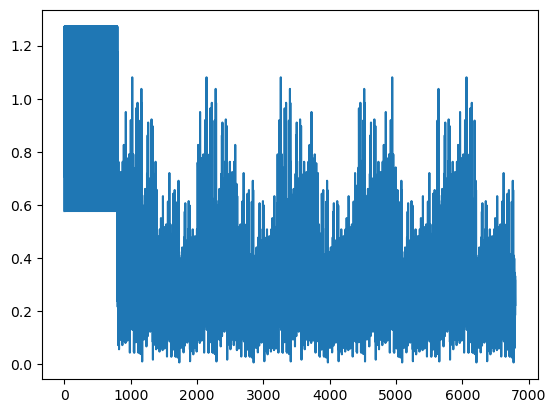

In [198]:
OFDM_packet = Generate_OFDM_Packet(actual_message)
plt.plot(abs(OFDM_packet[:6800]))
print('Length of OFDM packet',len(OFDM_packet))
print('Max power in dBm',10*np.log10(np.mean(abs(OFDM_packet)**2)))

In [199]:
''' Generate Unwatermarked OFDM Signal for Visualization Purposes'''
QPSK_IQ = Data_Frame(actual_message)
OFDM_data = OFDM_TX(QPSK_IQ)
unwatermaked_OFDM_signal = np.tile(OFDM_data,300)


Lenght of message: 96
Message Sent: 
I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.
Number of data bits: 672


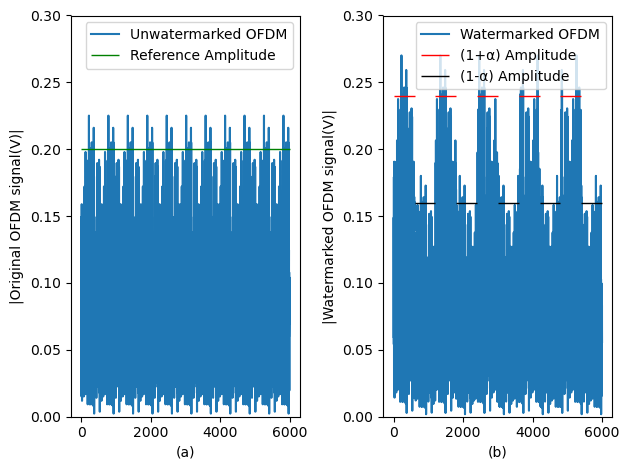

In [200]:
''' Plot Watermarket OFDM Packet'''
ax1 = plt.subplot(1, 2, 1)
ax1.plot(abs(0.5*unwatermaked_OFDM_signal[:6000])/2)
ax1.set_ylim([0,0.3])
plt.hlines(y = .2, color = 'green', xmin = 0, xmax = 6000, linewidth =1)
plt.ylabel('|Original OFDM signal(V)|')
plt.xlabel('(a)')

ax2 = plt.subplot(1, 2, 2)
ax2.plot(abs(OFDM_packet [800:6800])/4, label ="b")
ax2.set_ylim([0,0.3])
plt.hlines(y = .24, color = 'red', xmin = 0, xmax = 600, linewidth =1)
plt.hlines(y = .16, color = 'black', xmin = 600, xmax = 1200, linewidth =1)

plt.hlines(y = .24, color = 'red', xmin = 1200, xmax = 1800, linewidth =1)
plt.hlines(y = .16, color = 'black', xmin = 1800, xmax = 2400, linewidth =1)

plt.hlines(y = .24, color = 'red', xmin = 2400, xmax = 3000, linewidth =1)
plt.hlines(y = .16, color = 'black', xmin = 3000, xmax = 3600, linewidth =1)


plt.hlines(y = .24, color = 'red', xmin = 3600, xmax = 4200, linewidth =1)
plt.hlines(y = .16, color = 'black', xmin = 4200, xmax = 4800, linewidth =1)

plt.hlines(y = .24, color = 'red', xmin = 4800, xmax = 5400, linewidth =1)
plt.hlines(y = .16, color = 'black', xmin = 5400, xmax = 6000, linewidth =1)
plt.ylabel('|Watermarked OFDM signal(V)|')
plt.xlabel('(b)')
#plt.xlabel(r'$\alpha$')
ax1.legend(("Unwatermarked OFDM","Reference Amplitude"), loc = "upper right")
ax2.legend(("Watermarked OFDM","(1+α) Amplitude","(1-α) Amplitude"), loc = "upper right")
plt.tight_layout()
plt.savefig('PAM_Amplitudes.pdf')
plt.show()

In [201]:
# plt.psd(OFDM_packet, Fs = 2e6)#, Fc = 3655e6)
# plt.show()

In [202]:
np.mean(abs(OFDM_packet)**2)

0.126745298799916

In [203]:
def Calculate_mean(x):
    swap = np.zeros(10,)
    for i in range(10):
        swap[i] = sum(abs(x[i*samples:(i+1)*samples])**2)/samples
    return np.mean(swap), swap

Mean power is: 0.12214068427727591


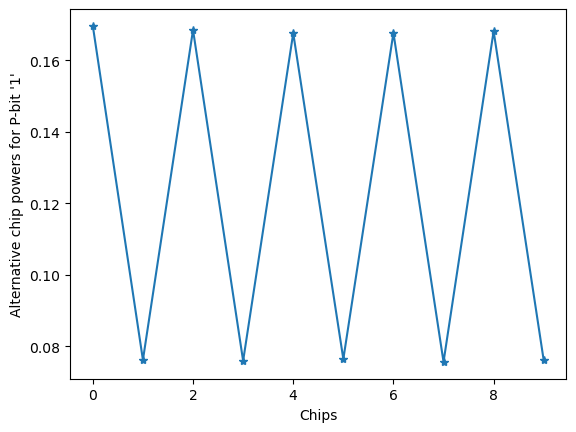

In [204]:
mean_power, power = Calculate_mean(OFDM_packet[len(Generate_HTSTF()):])
print('Mean power is:',mean_power)
plt.plot(power,marker = '*')
plt.ylabel("Alternative chip powers for P-bit '1'")
plt.xlabel("Chips")
plt.show()

In [205]:
# The SDR transmits IQ samples as IQIQIQ... patern 
# Convert complex to binary
def write_complex_binary(data, filename):
    
    '''
    Open filename and write array to it as binary
    Format is interleaved float IQ e.g. each I,Q should be 32-bit float 
    INPUT
    ----
    data:     data to be wrote into the file. format: (length, )
    filename: file name
    '''
    
    re = np.real(data)
    im = np.imag(data)
    binary = np.zeros(len(data)*2, dtype=np.float32)
    binary[::2] = re
    binary[1::2] = im
    binary.tofile(filename) 

In [206]:
# save generated signal to file
write_complex_binary(OFDM_packet, 'TX_watermark_Sept02_2024.iq')

In [207]:
# PURPOSE: perform preamble synchronization
#          Uses the (complex-valued) preamble signal. The cross-correlation 
#          of the preamble signal and the received signal (at the time
#          when the preamble is received) should have highest magnitude
#          at the index delay where the preamble approximately starts.  
# INPUT:   rx0: received signal (with a frequency offset)
#          preambleSignal: complex, known, transmitted preamble signal 
# OUTPUT:  lagIndex: the index of rx0 where the preamble signal has highest 
#              cross-correlation
#
def crossCorrelationMax(rx0, preambleSignal):

    # Cross correlate with the preamble to find it in the noisy signal
    lags      = signal.correlation_lags(len(rx0), len(preambleSignal), mode='valid')
    xcorr_out = signal.correlate(rx0, preambleSignal, mode='valid')
    xcorr_mag = np.abs(xcorr_out)
    # Don't let it sync to the end of the packet.
    packetLenSamples = 0#Pseudonym_Len*6000
    maxIndex = np.argmax(xcorr_mag[:len(xcorr_mag)-packetLenSamples])
    lagIndex = lags[maxIndex]

    print('Max crosscorrelation with preamble at lag ' + str(lagIndex))

    # Plot the selected signal.
    plt.figure()
    fig, subfigs = plt.subplots(2,1)
    subfigs[0].plot(np.real(rx0), label='Real RX Signal')
    subfigs[0].plot(np.imag(rx0), label='Imag RX Signal')
    scale_factor = np.mean(np.abs(rx0))/np.mean(np.abs(preambleSignal))
    subfigs[0].plot(range(lagIndex, lagIndex + len(preambleSignal)), scale_factor*np.real(preambleSignal), label='Preamble')
    subfigs[0].legend()
    subfigs[1].plot(lags, xcorr_mag, label='|X-Correlation|')
    plt.xlabel('Sample Index', fontsize=14)
    plt.tight_layout()
    plt.show()

    return lagIndex

Max crosscorrelation with preamble at lag 0


<Figure size 640x480 with 0 Axes>

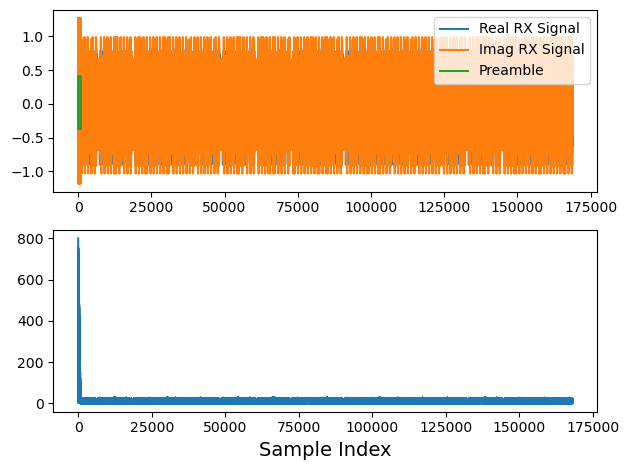

In [208]:
#data = np.zeros(len(OFDM_packet))
preambleSignal = Generate_HTSTF()
lagIndex = crossCorrelationMax(OFDM_packet,preambleSignal)

In [209]:
## Make p-bit decisions by comparing patterns on bit-0 and bit-1
## Trace changes in power with the p-bit and compare it with the known chip pattern.
## This algorithm improves pseudonym detection in the presence of non-Gaussion type interferences

def Matched_Filter_Pseudonym_Detection_Algorithm(x):
    matching_filter =np.array([1,-1,1,-1,1,-1,1,-1,1,-1])
    p_bit = []
    for i in range(28):
        pbit_data = x[i*packet:(i+1)*packet] # slices samples into one p-bit data = 6000 samples
        
        power = []
        Cr = []       
        threshold = 0.0
        quantization_level = np.array([1,-1])
        for j in range(10):
            chip_data = pbit_data[j*samples:(j+1)*samples] # slice p-bit data into chip data = 600 samples
            power.append(sum(abs(chip_data)**2))
       
        #plt.plot(power)
        #plt.show()

        for k in range(1,10):
            if power[k] > power[k-1]:
                Cr.append(quantization_level[0])
            else:
                Cr.append(quantization_level[1])
            
        pseudonym_power = np.dot(Cr,matching_filter[1:])#compute the pseudonym power by taking the inner product       

        if pseudonym_power > threshold: # p-bit decision done by comparing p-bit powers with the threshold.
            p_bit.append(1)
        else:
            p_bit.append(0)  
    return np.array(p_bit)

In [210]:
def binvector2str(binvector):
    #binvector = binvector[0]
    length = len(binvector)
    eps = np.finfo('float').eps
    if abs(length/7 - round(length/7)) > eps:
        print('Length of bit stream must be a multiple of 7 to convert to a string.')
    # Each character requires 7 bits in standard ASCII
    num_characters = round(length/7)
    # Maximum value is first in the vector. Otherwise would use 0:1:length-1
    start = 6
    bin_values = []
    while start >= 0:
        bin_values.append(int(math.pow(2,start)))
        start = start - 1
    bin_values = np.array(bin_values)
    bin_values = np.transpose(bin_values)
    str_out = '' # Initialize character vector
    for i in range(num_characters):
        single_char = binvector[i*7:i*7+7]
        value = 0
        for counter in range(len(single_char)):
            value = value + (int(single_char[counter]) * int(bin_values[counter]))
        str_out += chr(int(value))
    return str_out

In [211]:
start_of_data = lagIndex + len(preambleSignal)
pseudonym_estimate = Matched_Filter_Pseudonym_Detection_Algorithm(OFDM_packet[start_of_data:])

print('The detected pseudonym message is:', binvector2str(pseudonym_estimate))


The detected pseudonym message is: STOP


In [212]:
RX_signal = OFDM_packet[start_of_data:]
print(len(RX_signal))

168000


In [213]:
def Channel_Estimation(x):
    pilots = x[pilotCarriers] 
    H_at_pilots = pilots / pilotValue 
    
    # Perform interpolation between the pilot carriers to get an estimate of the channel in the data carriers. 
    H_abs=scipy.interpolate.interp1d(pilotCarriers, abs(H_at_pilots), kind='nearest', fill_value='extrapolate')(allCarriers)
    H_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(H_at_pilots), kind='nearest',fill_value = 'extrapolate')(allCarriers)
    H_estimate = H_abs * np.exp(1j*H_phase)
    
    return H_estimate

In [214]:
def Equalization(OFDM_demod, Hest):
    return OFDM_demod / Hest

In [215]:
def OFDM_RX(data):
    for i in range(len(data)//(OFDM_size)):
        data_cp = data[i*(OFDM_size):(i+1)*(OFDM_size)]
        data_without_cp = data_cp[CP:]
        
        # Generate frequency domain signal
        OFDM_freq = np.fft.fft(data_without_cp,n=FFT)
       
        H_est = Channel_Estimation(OFDM_freq) # estimate the channel
        
        OFDM_est = Equalization(OFDM_freq,H_est) # equalization with estimated channel
        
        OFDM_data = OFDM_est[dataCarriers] # extract the data signal
        # OFDM_data = OFDM_freq[dataCarriers] # extract the data signal
        
        if i == 0:
            OFDM_swap =  OFDM_data
        else:
            OFDM_signal = np.concatenate((OFDM_swap,  OFDM_data))
            OFDM_swap = OFDM_signal
    #         print('Length of waveform:',len(OFDM_swap))
    return OFDM_signal

In [216]:
# PURPOSE: Plot the signal symbol samples on a complex plane
# INPUT:   Received complex values (output of matched filter downsampled)
# OUTPUT:  none
def constellation_plot(rx4):
    # I like a square plot for the constellation so that both dimensions look equal
    plt.figure(figsize=(5,5))
    ax = plt.gca() 
    ax.set_aspect(1.0) # Make it a square 1x1 ratio plot
    plt.plot(np.real(rx4), np.imag(rx4),'ro')
    plt.ylabel('Imag(Symbol Sample)', fontsize=14)
    plt.xlabel('Real(Symbol Sample)', fontsize=14)
    plt.grid('on')
    plt.tight_layout()
    plt.show()

In [217]:
# Purpose: Convert M-ary data to binary data
#          each m-ary value input in "data" is converted to
#          log2(M) binary values.
# INPUT: M-ary digit vector
# OUTPUT: Binary digit vector, with length equal to the number
#         of values in data multiplied by log2(M)
def mary2binary(data, M):
    length = len(data) # number of values in data
    log2M = round(np.log2(M)) # integer number of bits per data value
    format_string = '0' + str(log2M) + 'b'
    binarydata = np.zeros((1,length*log2M))
    count = 0
    for each in data:
        binval = format(int(each), format_string)
        for i in range(log2M):
            binarydata[0][count+i] = int(binval[i])
        count = count + log2M
    return binarydata

In [218]:
# PURPOSE: Find the symbols which are closest in the complex plane 
#          to the measured complex received signal values.
# INPUT:   Received r_hat values (output of matched filter downsampled),
#          and possible signal space complex values. 
# OUTPUT:  m-ary symbol indices in 0...length(outputVec)-1
def findClosestComplex(r_hat, outputVec):
    # outputVec is a 4-length vector for QPSK, would be M for M-QAM or M-PSK.
    # This checks, one symbol sample at a time,  which complex symbol value
    # is closest in the complex plane.
    data_out = [np.argmin(np.abs(r-outputVec)) for r in r_hat]
    return data_out

In [219]:
def QPSK_Data_Demodulation(x):
    outputVec = np.array([1+1j, -1+1j, 1-1j, -1-1j])
    for i in range(len(x)//mess_length):
        time_signal = x[i*mess_length:(i+1)*mess_length]
        detected_signal = OFDM_RX(time_signal)
        constellation_plot(detected_signal)
        mary_out  = findClosestComplex(detected_signal, outputVec)
        data_bits  = mary2binary(mary_out, 4)[0]
        extract_message = binvector2str(data_bits)
        print(extract_message)

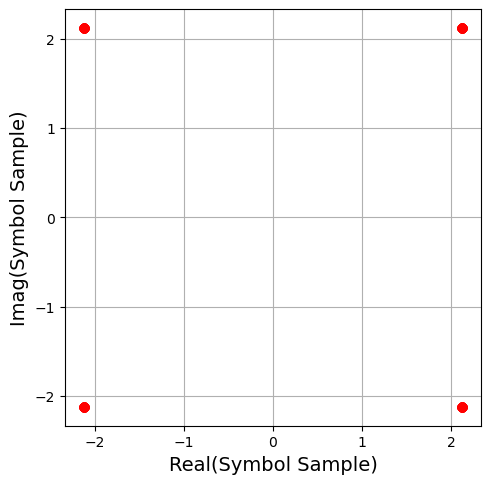

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


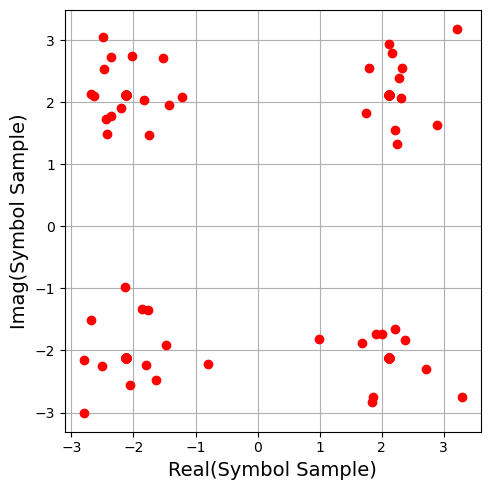

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


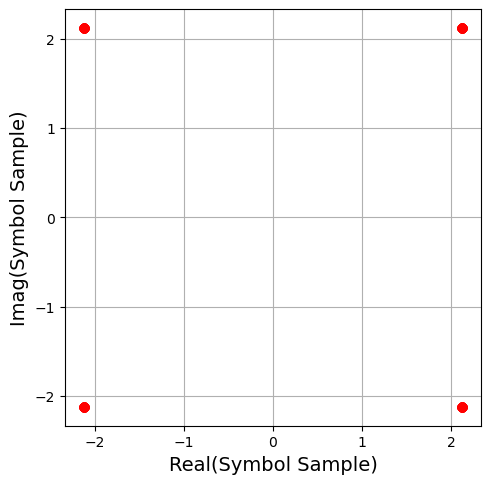

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


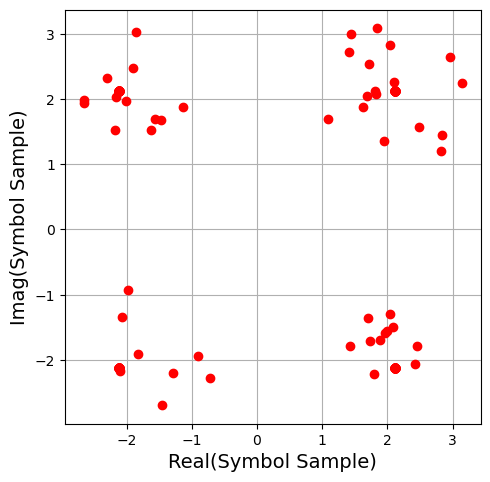

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


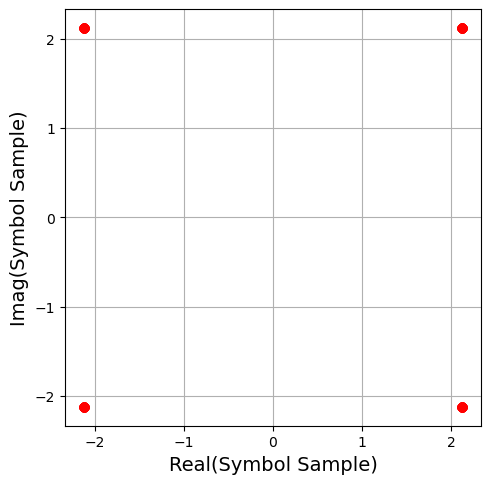

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


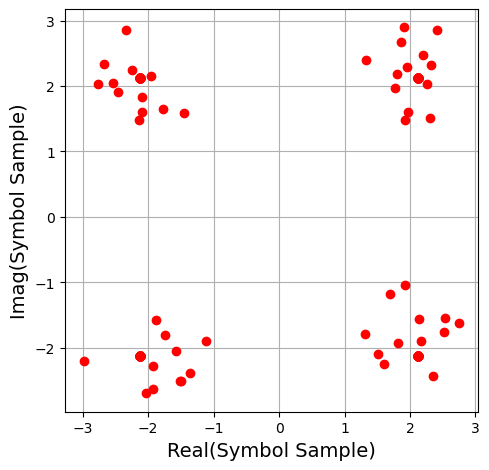

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


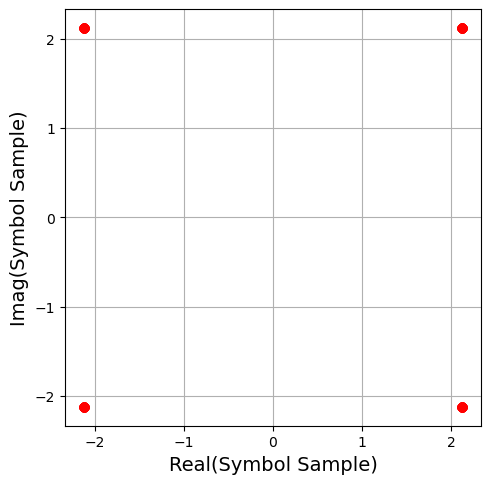

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


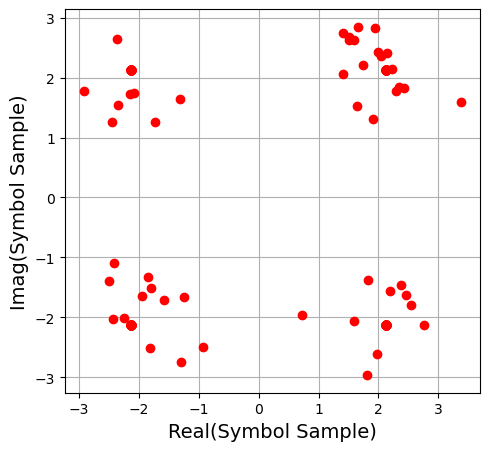

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


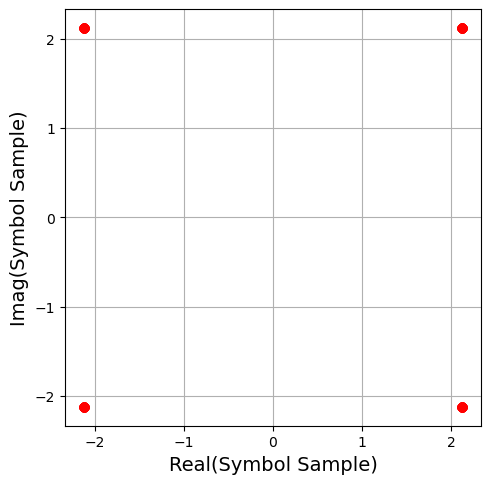

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


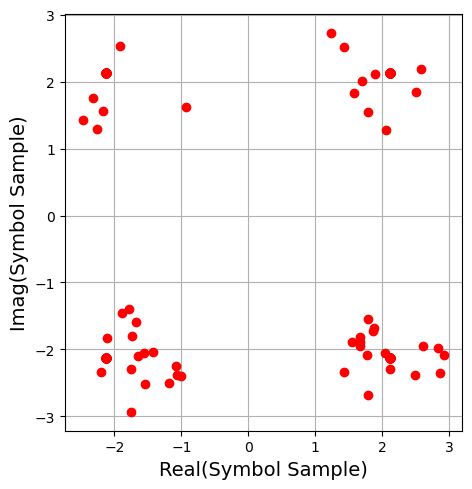

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


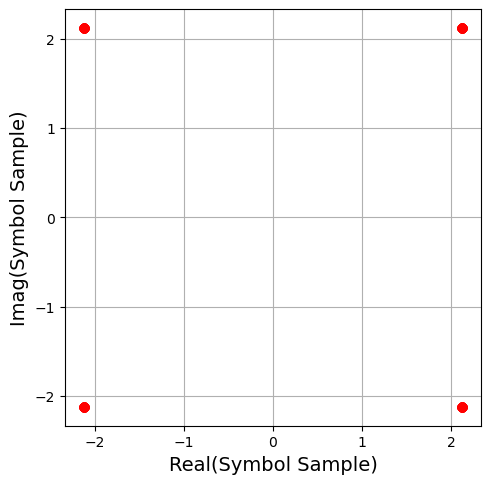

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


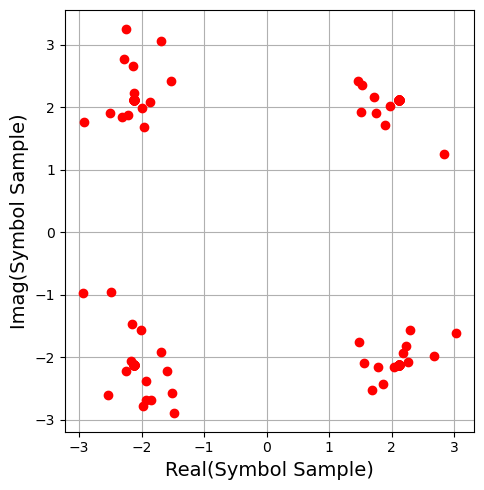

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


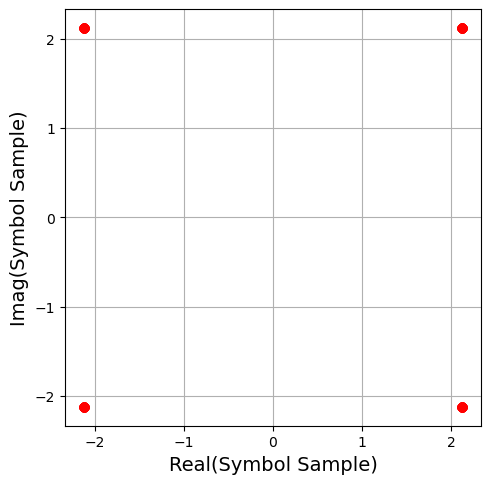

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


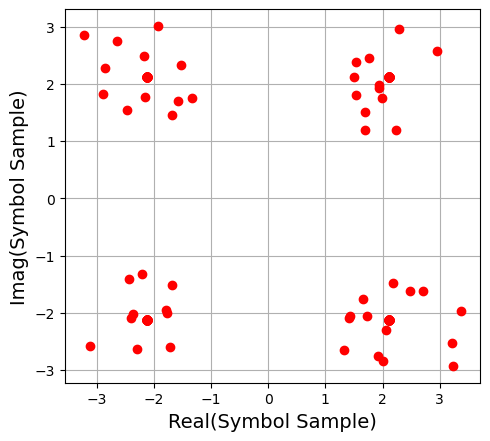

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


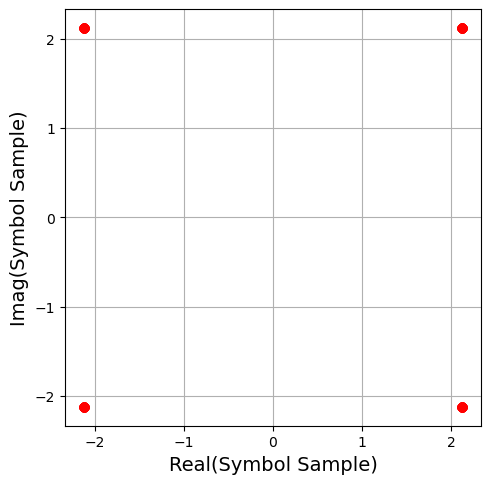

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


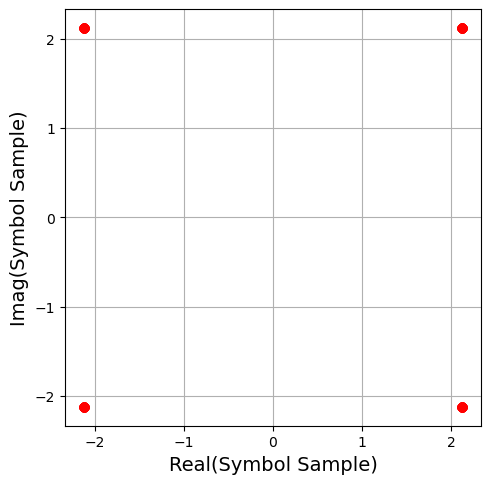

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


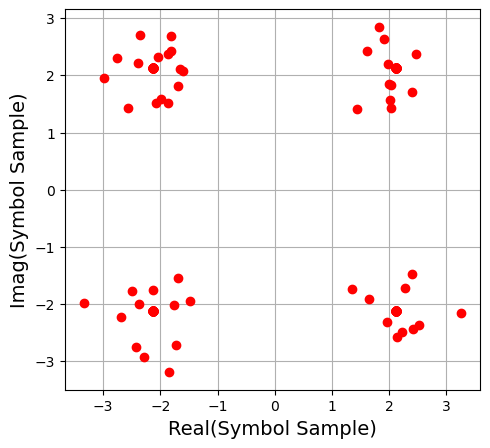

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


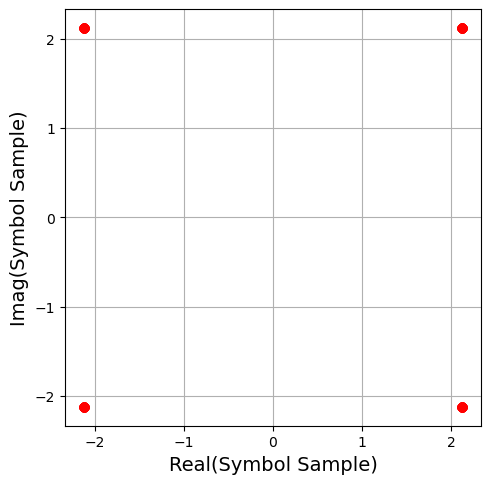

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


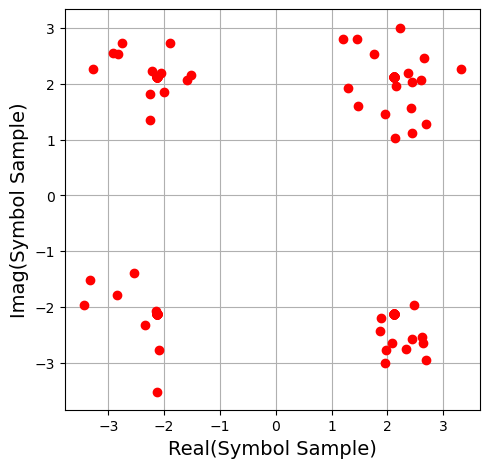

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


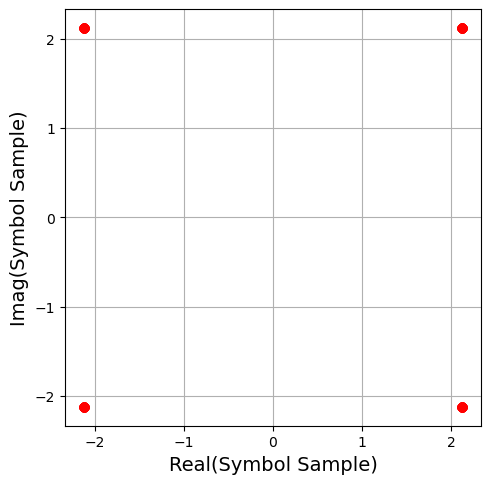

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


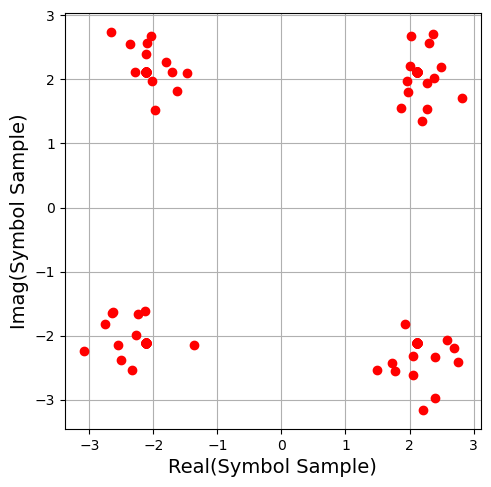

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


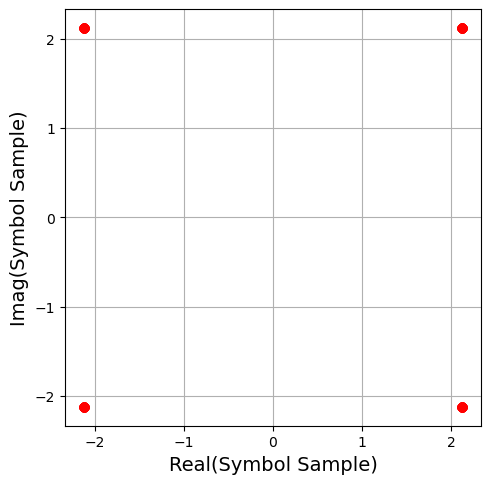

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


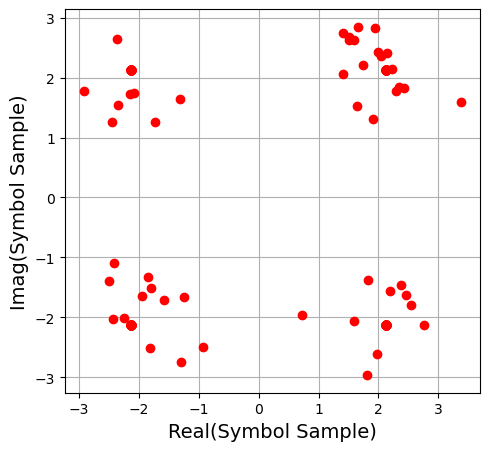

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


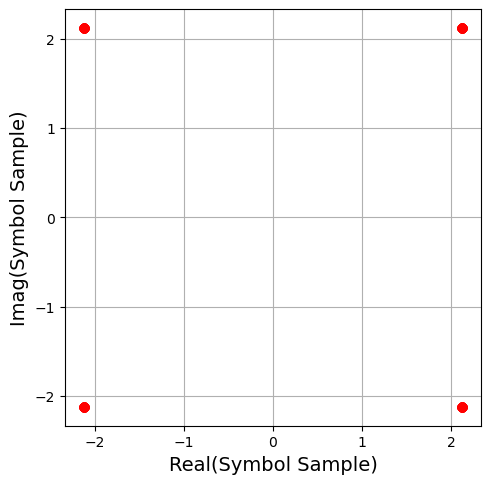

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


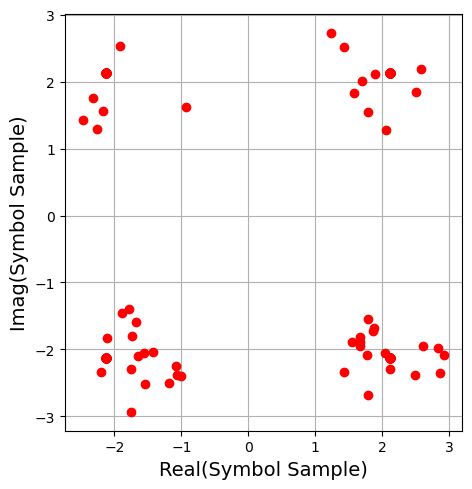

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


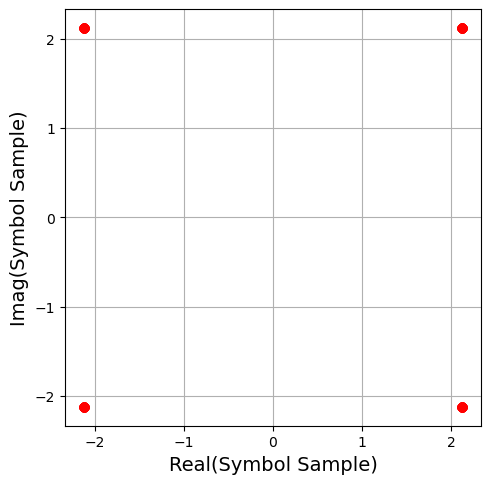

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


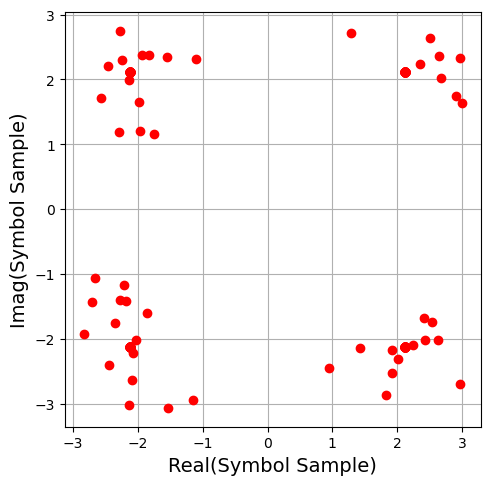

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


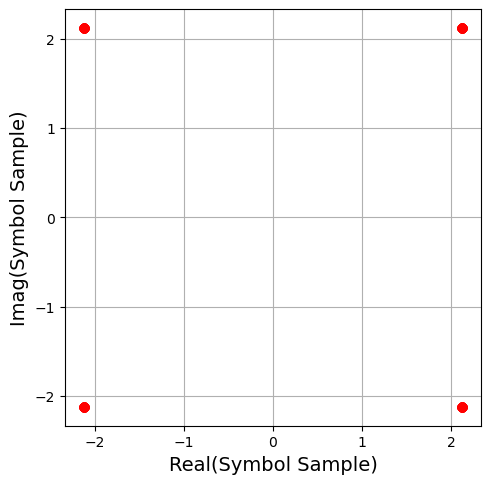

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


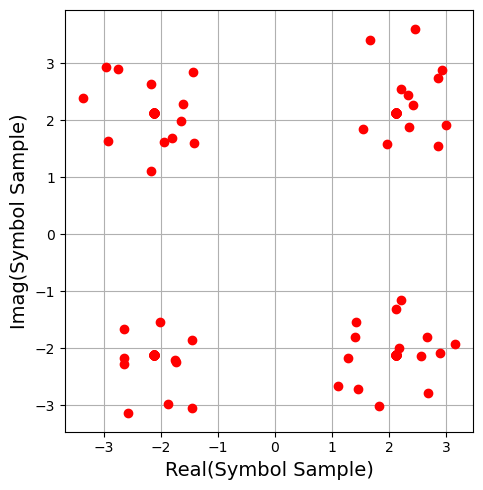

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


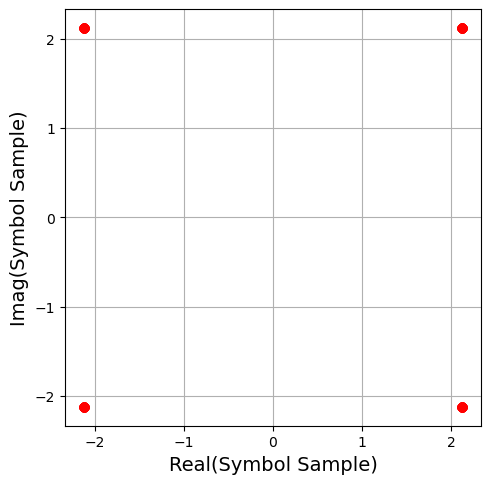

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


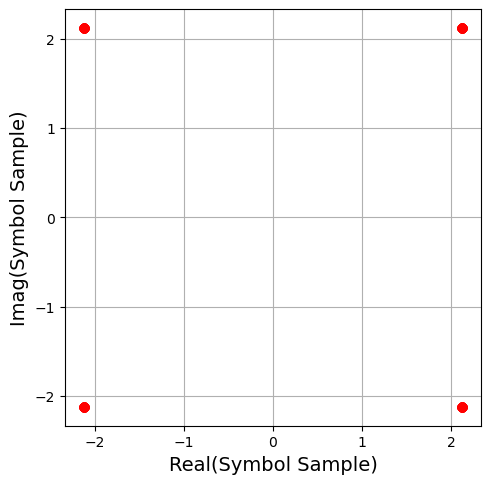

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


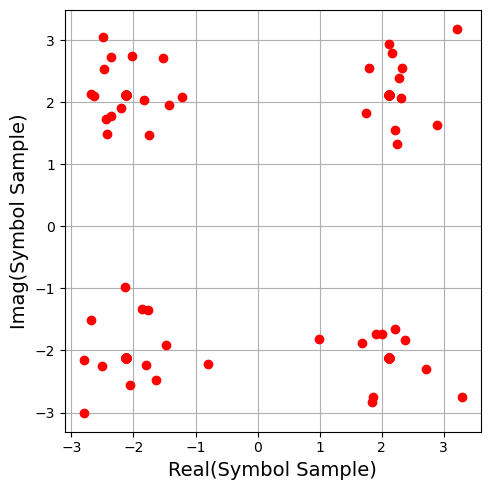

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


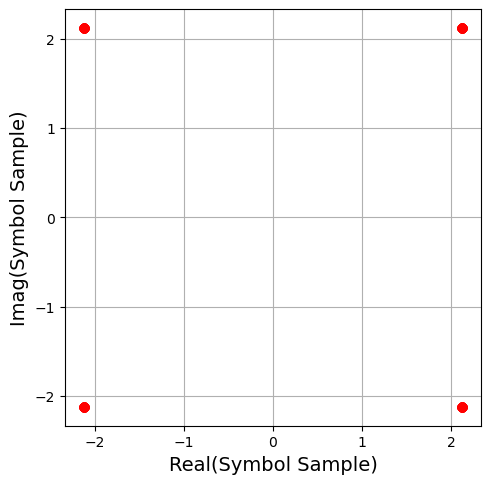

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


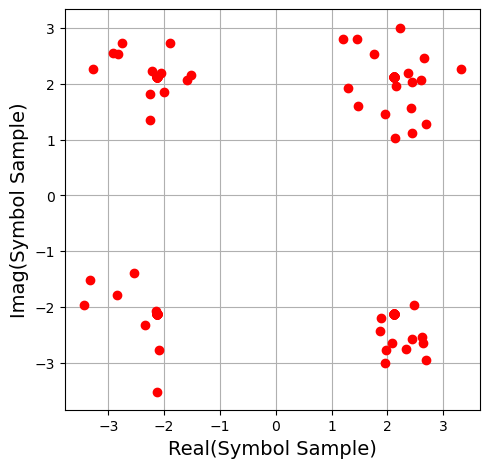

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


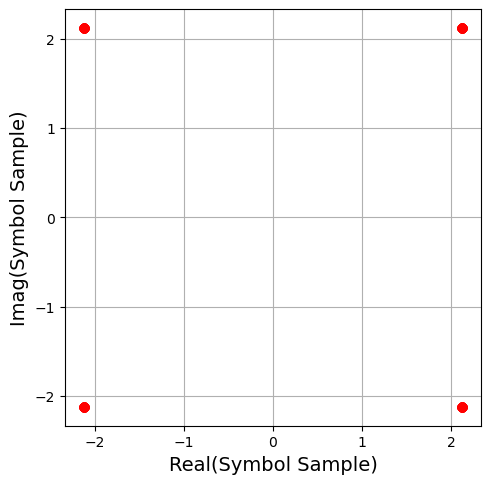

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


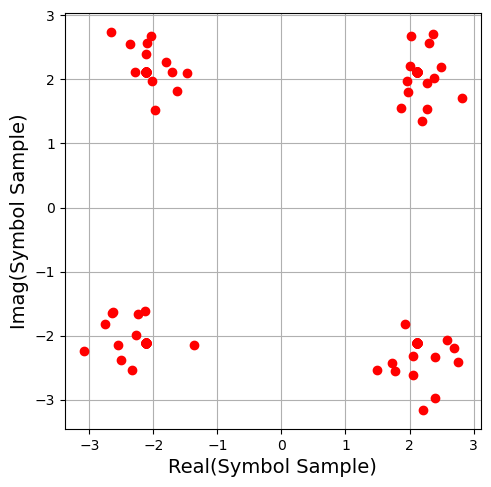

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


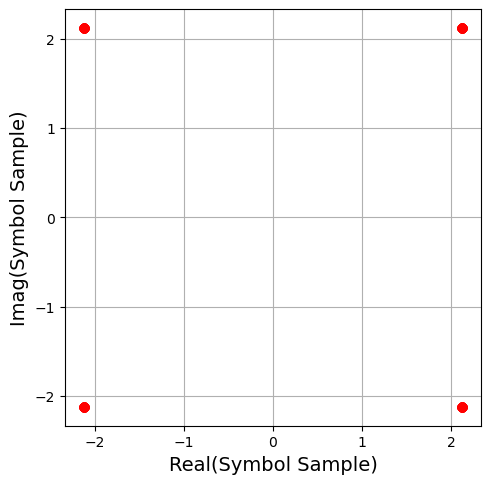

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


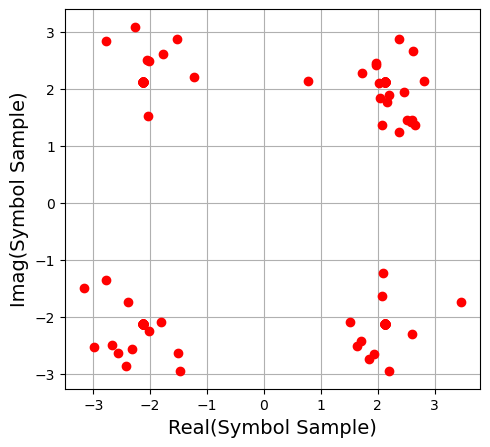

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


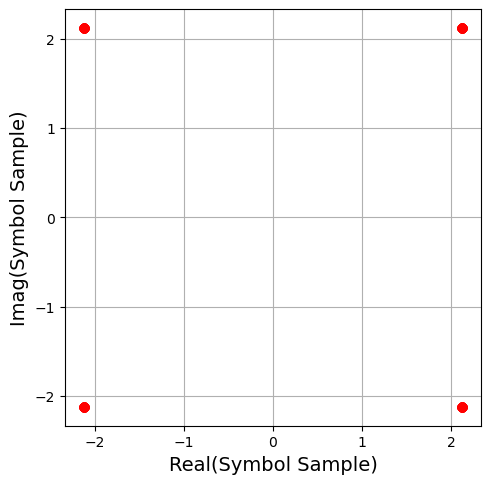

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


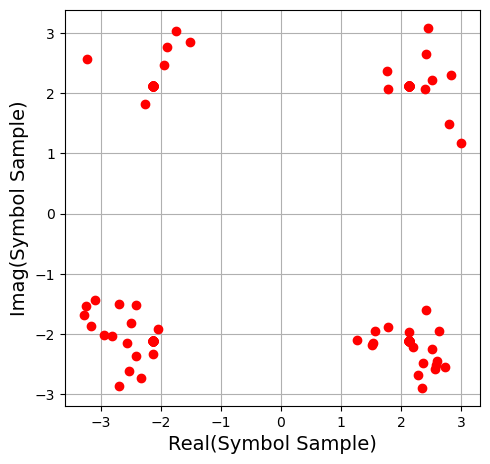

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


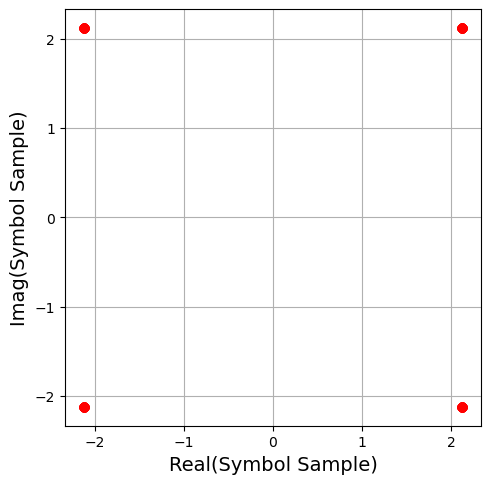

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


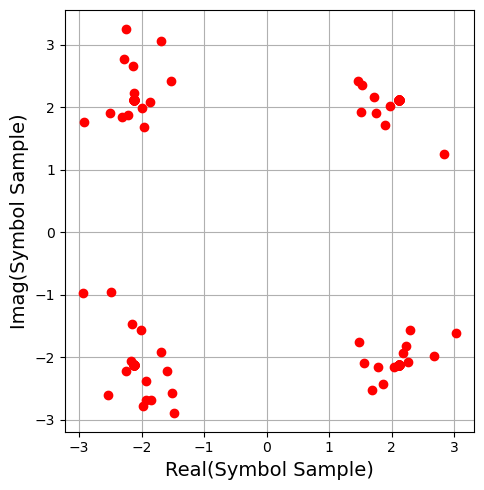

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


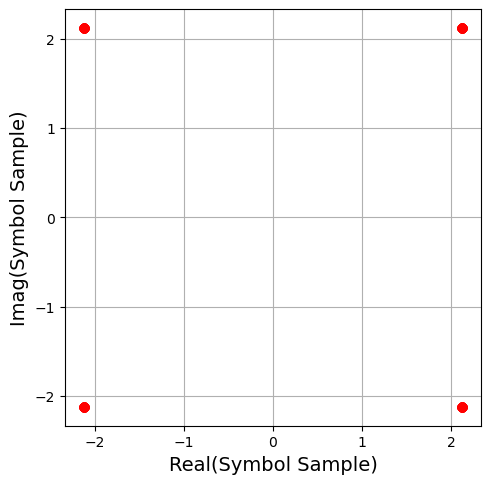

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


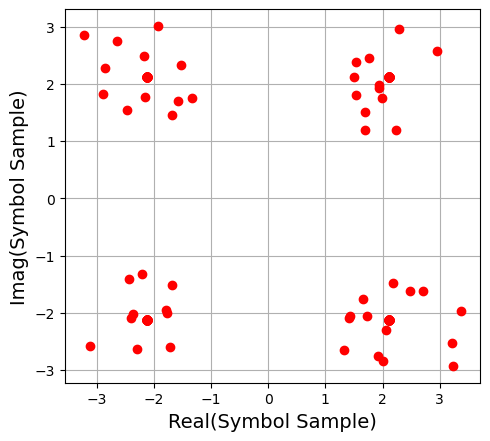

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


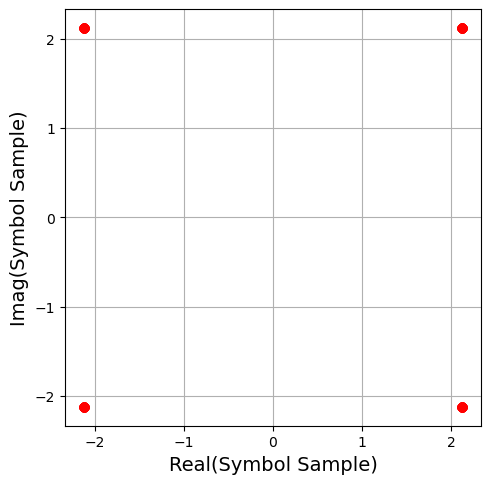

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


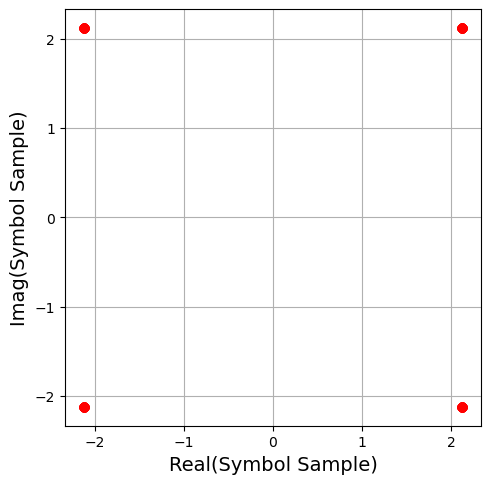

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


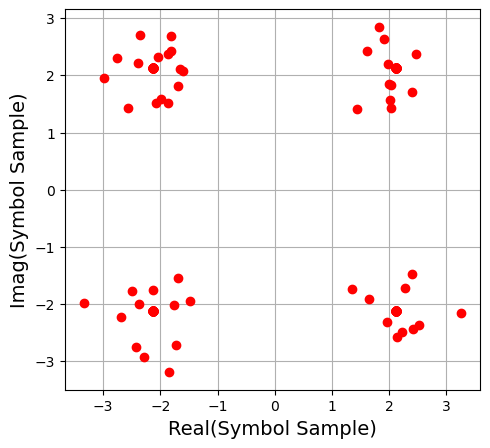

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


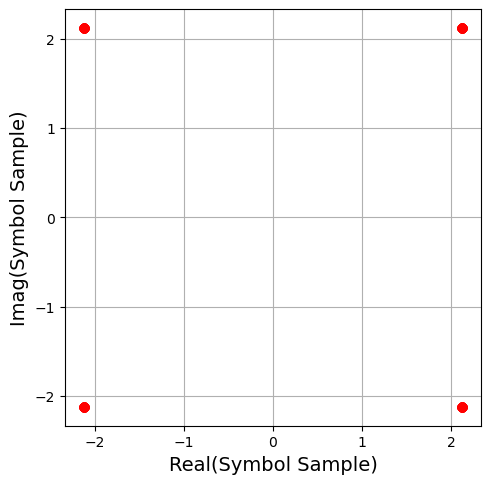

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


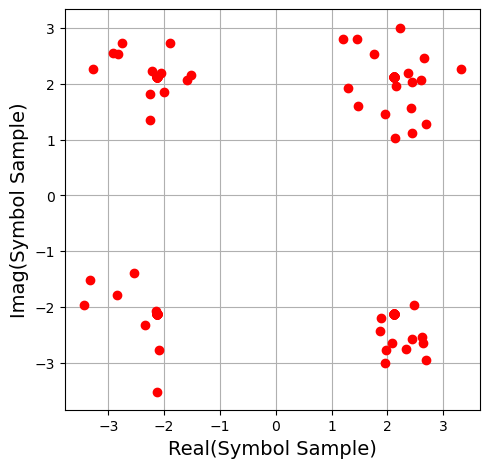

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


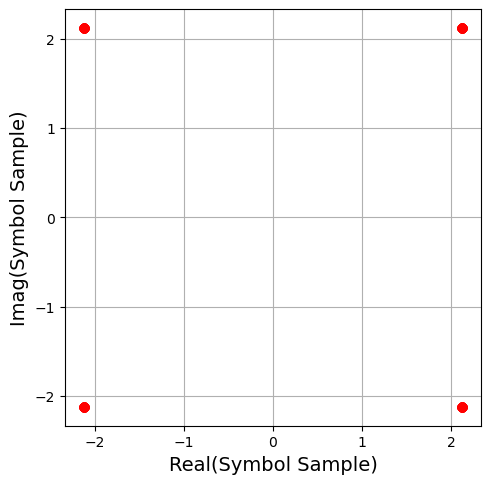

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


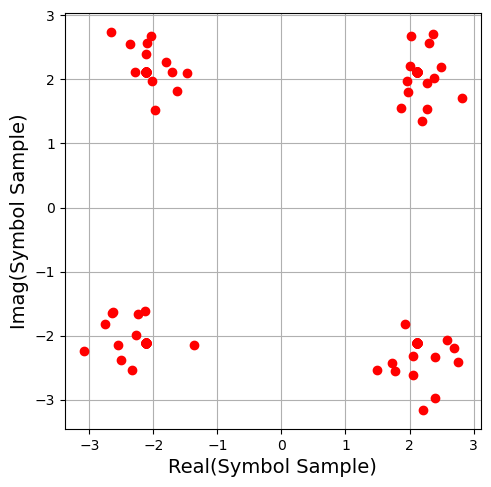

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


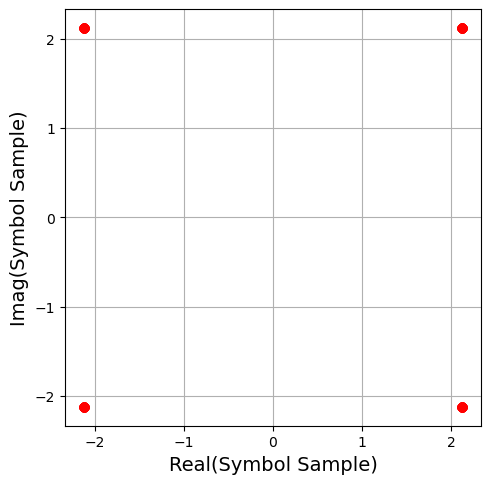

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


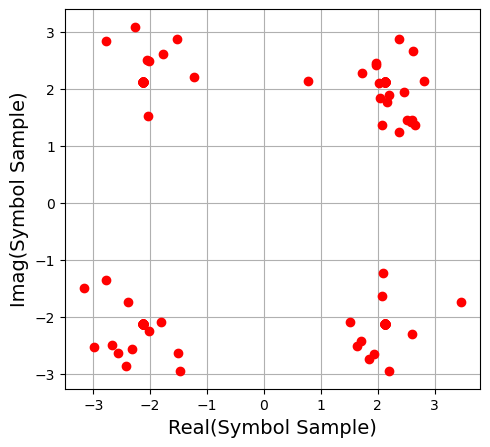

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


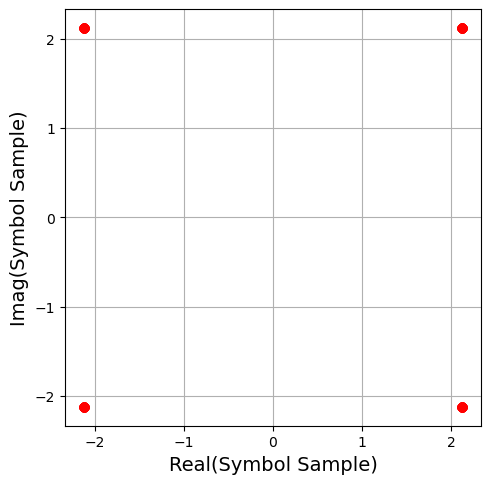

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


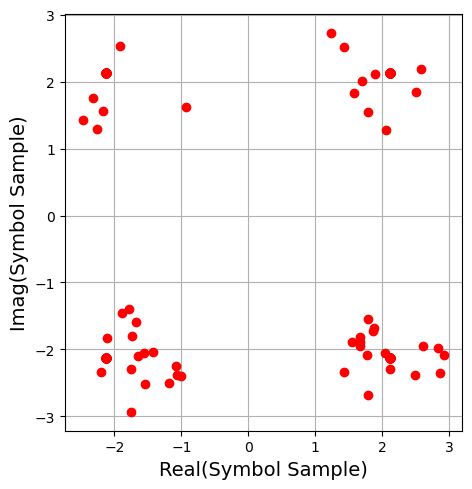

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


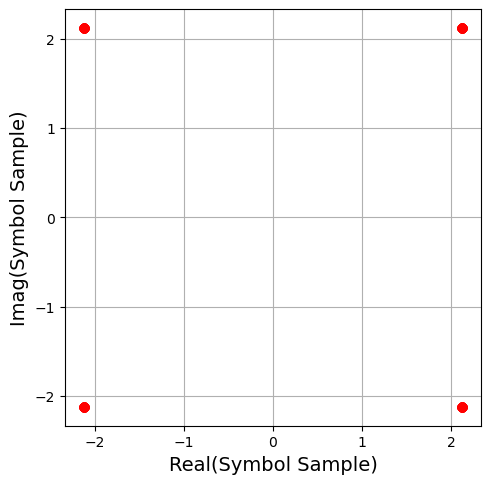

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


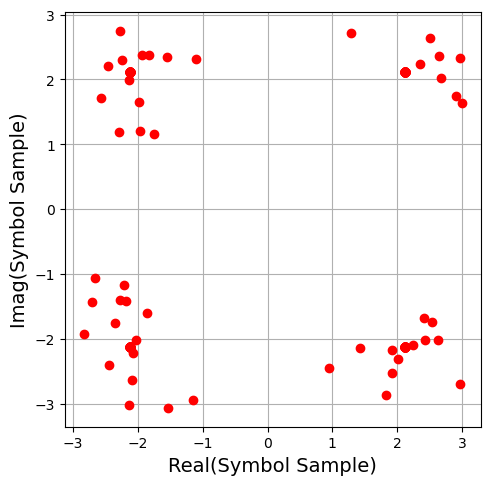

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


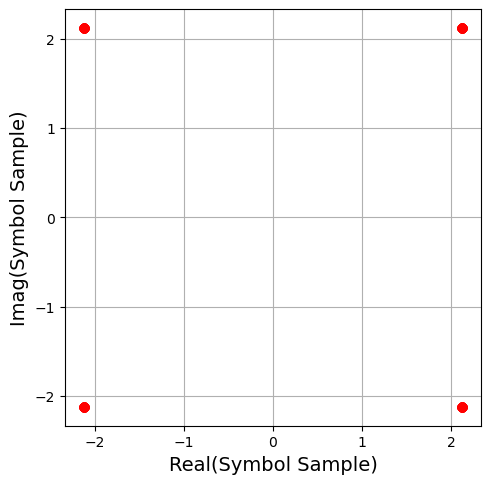

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


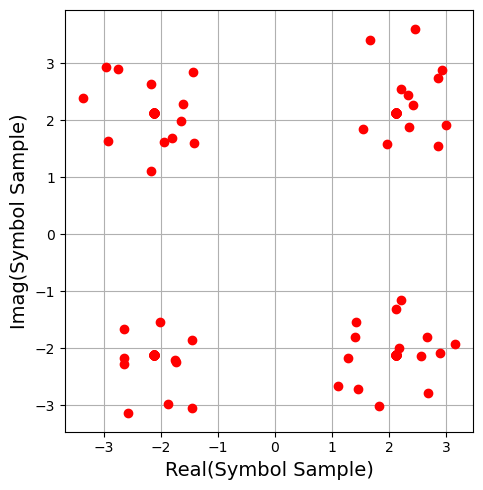

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


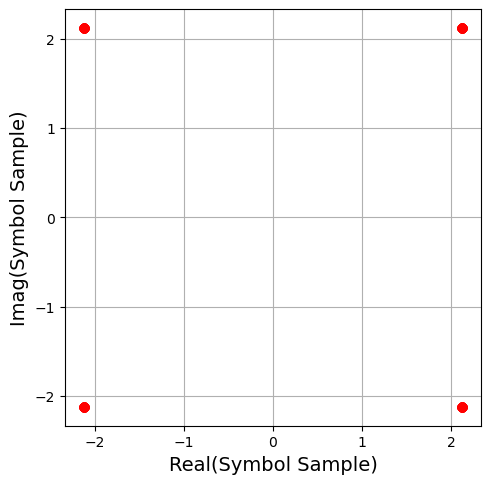

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


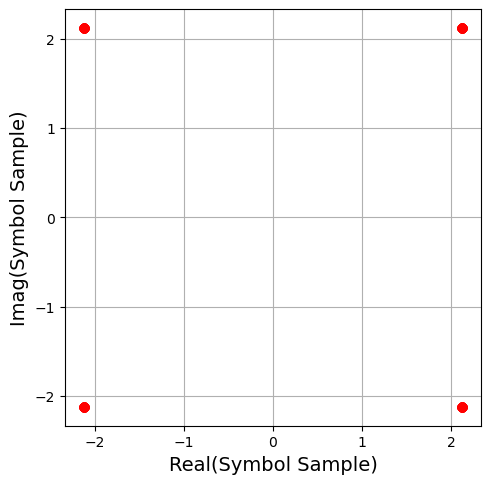

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


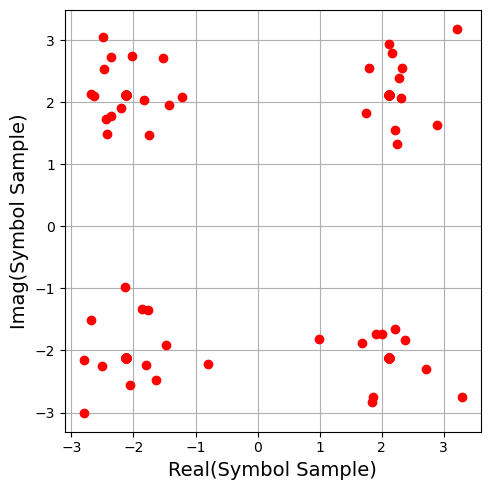

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


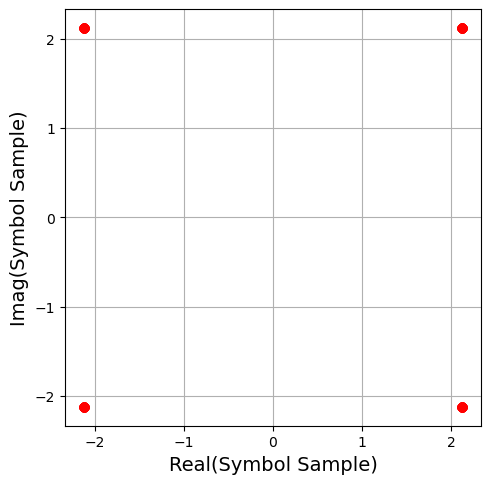

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


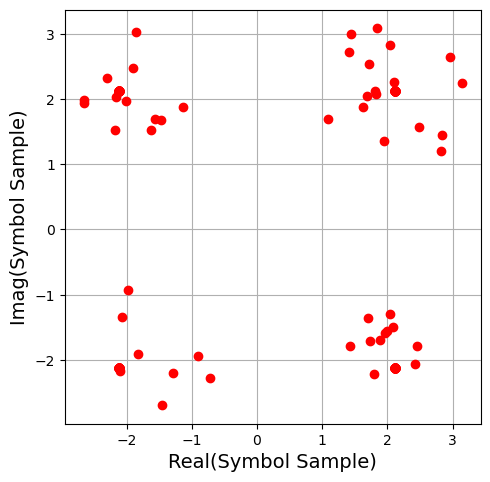

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


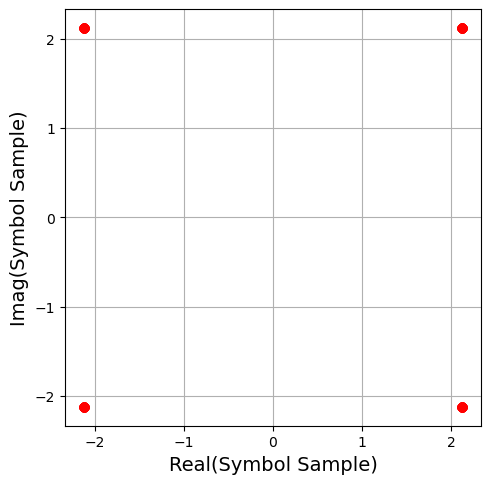

I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.


In [ ]:
QPSK_Data_Demodulation(RX_signal)

In [ ]:
def get_samps_from_file(filename): 
    '''
    load samples from the binary file
    '''
    # File should be in GNURadio's format, i.e., interleaved I/Q samples as float32
    samples = np.fromfile(filename, dtype=np.float32)
    samps = (samples[::2] + 1j*samples[1::2]).astype((np.complex64)) # convert to IQIQIQ  
    return samps

In [ ]:
RX_data = get_samps_from_file('RX_data1.iq')
len(RX_data)
RX_data[0:10]

In [ ]:
RX_noise = get_samps_from_file('RX_noise.iq')

In [ ]:
p_rx = np.mean(abs(RX_data)**2)
p_no = np.mean(abs(RX_noise)**2)

snr = 10*np.log10((p_rx-p_no)/p_no)
print('The measured SNR:',snr)

In [ ]:
#preambleSignal = Generate_HTSTF()
lagIndex = crossCorrelationMax(RX_data[:600000],preambleSignal)

In [ ]:
start_of_data = lagIndex + len(preambleSignal)
pseudonym_estimate = Matched_Filter_Pseudonym_Detection_Algorithm(RX_data[start_of_data:start_of_data+168000])

print('The detected pseudonym message is:', binvector2str(pseudonym_estimate))


In [ ]:
# Load train dataset from file
def readCom(file_path):
    return np.fromfile(file_path, dtype=np.complex64)

In [ ]:
gnuradio_data = readCom('gnuradio_RX_data.dat')

lagIndex = crossCorrelationMax(gnuradio_data[:600000],preambleSignal)

In [ ]:
start_of_data = lagIndex + len(preambleSignal)
pseudonym_estimate = Matched_Filter_Pseudonym_Detection_Algorithm(gnuradio_data[start_of_data:start_of_data+168000])

print('The detected pseudonym message is:', binvector2str(pseudonym_estimate))


In [ ]:
# QPSK_Data_Demodulation(gnuradio_data[start_of_data:start_of_data+168800])

In [ ]:
a =text2bits("&F*f"&G.*2Ff2N.tJNof.n.w&."/>.~wNn/'JNs%}<$-qJF6j>^."Nrrf6"')

In [ ]:
b =text2bits('I have worked in SPAN Lab for the last three & half years.I implemented Pseudonymetry in POWDER.')

In [ ]:
print(a[:10])
print(b[:10])